<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Прекрасное вступление!
    
В нём есть всё, что необходимо, чтобы понять суть проекта с первых строк отчёта!
    
Спасибо, что есть оглавление в плагине toc и в виде гиперссылок - по проекту удобно перемещаться:)

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.dummy import DummyRegressor
from statsmodels.tsa.stattools import adfuller

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Библиотеки импортировали - отлично! Спасибо, что перезапускаешь проект перед отправкой на ревью - это важный шаг, который поможет избежать простых и досадных ошибок при воспроизведении решнеия:)
</div>

## Подготовка

Загрузим и рассморим данные

In [2]:
data = pd.read_csv('/datasets/taxi.csv')
print(data.isna().sum())
print()
data.info()

datetime      0
num_orders    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Данные подгрузили и проверили.
    
При считывании данных из файла здорово перестраховывать себя от ошибок, связанных, например, с неверным указанием пути к файлу. А иногда бывает, что работаешь с файлом локально, выгружаешь его на сервер, ожидая, что он будет принимать данные, которые лежат на том же сервере, а код падает с ошибкой, потому что путь к файлу не поменялся с локального на серверный.
    
Для этого, например, можно использовать конструкцию `try-except`: сначала пробуешь локальный путь, при возникновении ошибки используется серверный путь (подробнее можешь почитать тут: https://pythonworld.ru/tipy-dannyx-v-python/isklyucheniya-v-python-konstrukciya-try-except-dlya-obrabotki-isklyuchenij.html).
    
Но еще лучше использовать библиотеку `os` - её использование позволит тебе отойти от прописывания путей к файлу (а локальные директории могут меняться часто в зависимости от пользователя) и перейти к автоматическому определению пути к файлу с помощью модуля `path`. Как пример:
    
    import os

    pth1 = '/folder_1/data.csv'
    pth2 = '/folder_2/data.csv'
    
    if os.path.exists(pth1):
        query_1 = pd.read_csv(pth1)
    elif os.path.exists(pth2):
        query_1 = pd.read_csv(pth2)
    else:
        print('Something is wrong')
    
В нём мы указываем только непосредственно директорию с файлом, а уже путь к ней модуль `path` определит самостоятельно.

Также ещё на этапе считывания данных можно спарсить дату и задать индекс-столбец: за первое действие отвечает параметр `parse_dates`, за второе - `index_col`. Это параметры метода Pandas `.read_csv()`.
</div>

Пропусков в данных нет, теперь подготовим данные к решению задачи регрессии на временных рядах. 

In [3]:
data["datetime"] = pd.to_datetime(data["datetime"], format = "%Y-%m-%d %H:%M:%S")
data = data.set_index("datetime")

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Преобразовали дату и задали её как индекс таблицы - окей!
</div>

По условиям задачи необходима информация по количеству заказов такси на каждый час. Ресемплируем данные по 1 часу. В качестве агрегирующей функции возьмем сумму, так как необходимо предсказывать суммарное количество заказов на следующий час.

In [4]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Выполнили ресэмплирование данных с градацией по часу с применением функции суммирования - отличное и наиболее логичное решение для этой задачи!
</div>

## Анализ

Проведем анализ временных рядов. Рассмотрим график временного ряда.

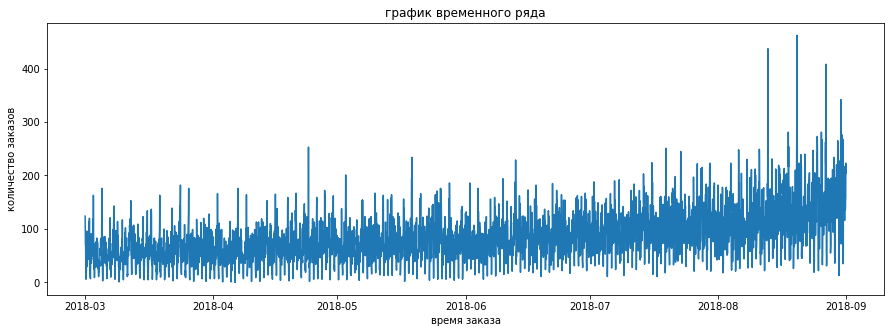

In [5]:
plt.figure(figsize=(15, 5))
plt.plot(data)
plt.title("график временного ряда")
plt.xlabel("время заказа")
plt.ylabel("количество заказов")
plt.show()

По графику сложно понять происходящее с данными и выявить какие-то закономерности, но виден тренд на повышение заказов с течением времени. Построим график с учетом скользящего среднего.

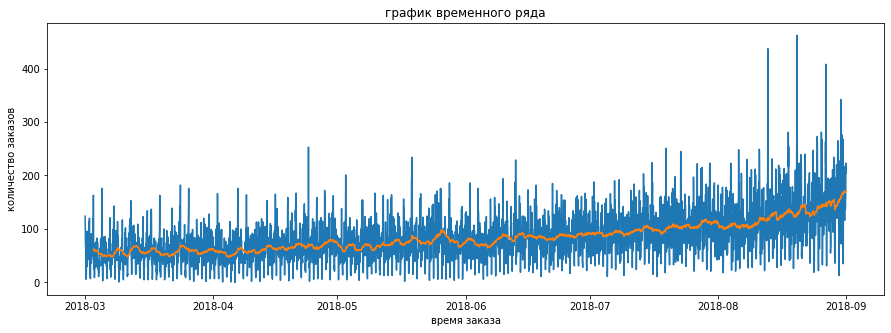

In [6]:
data["rolling_mean"] = data["num_orders"].shift().rolling(50).mean()
plt.figure(figsize=(15, 5))
plt.plot(data)
plt.title("график временного ряда")
plt.xlabel("время заказа")
plt.ylabel("количество заказов")
plt.show()

По графику видно, тренд на увелечение количества заказов в час, рассмотрим тренды и сезонность поближе.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Сгладили исходный врмеменной ряд скользящей средней - окей!
</div>

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> 

При использовании `.rolling()` в такой постановке скользящее среднее считается с учётом текущего шага - это не совсем верно для задачи временных рядов, так как будет работать только для известных нам значений и сломается на предсказаниях.
        
Нужно либо использовать `.shift()` перед `.rolling()`, либо параметру `closed` при использовании `.rolling()` передать значение `left`.
</div>

<div class="alert alert-warning">
    <h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> 

Не учтено.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.3 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Учтено!
</div>

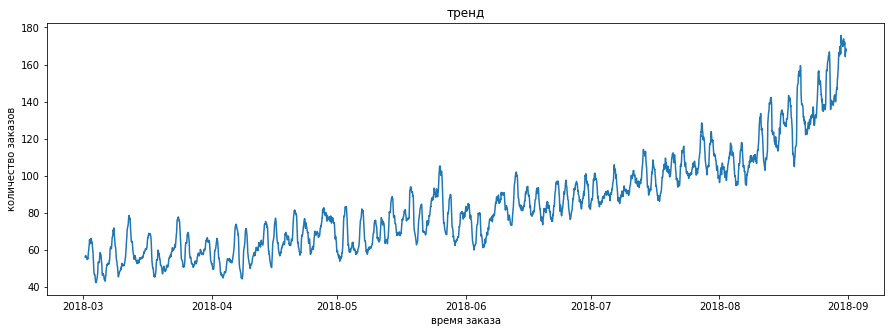

In [7]:
decomposed = seasonal_decompose(data["num_orders"])
plt.figure(figsize=(15, 5))
plt.plot(decomposed.trend)
plt.title("тренд")
plt.xlabel("время заказа")
plt.ylabel("количество заказов")
plt.show()

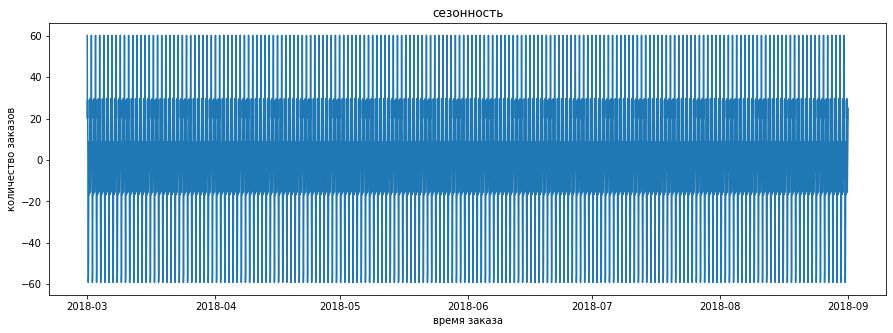

In [8]:
plt.figure(figsize=(15, 5))
plt.plot(decomposed.seasonal)
plt.title("сезонность")
plt.xlabel("время заказа")
plt.ylabel("количество заказов")
plt.show()

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
В номинации `Самый информативный график` побеждает :D 
    
Чуть ниже будет коммент по этому поводу:)
</div>

Как и ожидалось из графика скользящего среднего есть четкий тренд на повышение количества заказов с каждым месяцем. Это обьясняестя тем, что в летние месяцы люди летают больше, соответственно и заказывают такси в аэропорты больше. Сезонность по историческим данным не наблюдается, так как даны данные только за полгода. Возможна есть какая-то сезонность если рассматривать данные за несколько лет, но отследить ее на полугодовом отрезке не представляется возможным.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Тут всё чётенько!
</div>

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
Аналитическую часть этого раздела стоит дополнить:
    
1. Сезонную компоненту для лушчего понимания природы сезонности стоит дополнительно исследовать на более коротком промежутке времени - подойдёт 3-5 суток (а то синий квадрат правда не очень информативен). Для выполнения этого пункта стоит найти ответы на следующие вопросы:
    
- какова природа сезонности (часовая, суточная, дневная, недельная, месячная)?;
    
- в какие периоды (с учётом пункта выше) наблюдаются пики заказов, а в какие - спады?;
    
- чем обсуловлена природа сезонности? (важно помнить, что у нас данные про заказы такси в аэропортах - как это соотносится с пунктом выше).
    
    Давай постараемся не упустить ни один из пунктов?:)

2. Важно визуализировать и проанализировать остатки после декомпозиции временного ряда. Тут можно сделать предположение о стационарности ряда - если остатки ведут себя стабильно и не показывают разброс с течением времени - можно предположить стационарность ряда, и наоборот -  и плавно перейти к п.3.

3. Стоит оценить стационарность ряда и сделать об этом вывод. Сделать это можно с помощью сглаживания скользящим средним и последующей визуализацией сглаженного ряда на графике (отлично будет смотреться на графике исходного временного ряда как его дополнение) - это самый простой способ (частично ты его уже сделал, надо только прокомментировать). В реальных же задачах с временными рядами, в особенности - с финансовыми данными или биржевыми котировками, график не всегда поможет достоверно оценить стационарность ряда. Поэтому для оценки стационарности ряда лучше использовать тест Дики — Фуллера (подробнее о нём можно глянуть тут: https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html, а вот тут можно глянуть пример реализации: https://www.helenkapatsa.ru/tiest-diki-fulliera/) - он даст наиболее точный результат. Рекомендую попробовать оба способа - важно понимать, как соотносятся результаты двух способов. Также тест Дики-Фуллера стоит провести на двух уровнях значимости - 1% и 5%. Может, результаты будут отличаться? Как в таком случае поступим?

</div>

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Рассмотрим график остатков
</div>

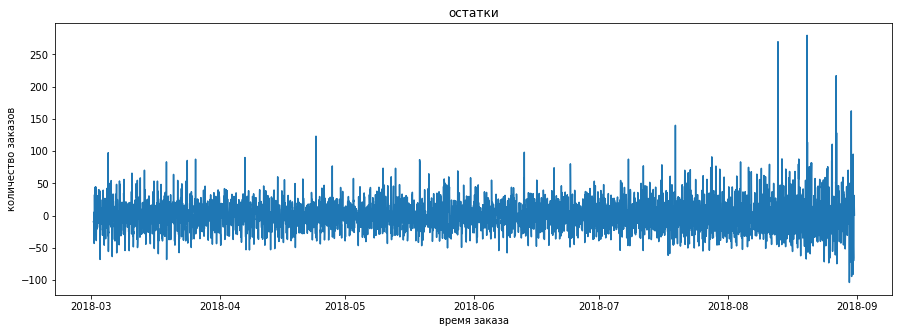

In [9]:
plt.figure(figsize=(15, 5))
plt.plot(decomposed.resid)
plt.title("остатки")
plt.xlabel("время заказа")
plt.ylabel("количество заказов")
plt.show()

Разброс остатков большой, можно сказать, что ряд не стационарный. Теперь необходимо рассмотреть поближе сезонность ряда. Рассмотрим срез ряда длиной в 5 суток, декомпозируем его и рассморим сезонность.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>

Вывод некорректный: стационарность/нестационарность ряда не может объясняться наличием тренда в ряде - в ряде так или иначе всегда будет какой-то тренд.
    
В целом вывода `Разброс остатков большой, можно сказать, что ряд не стационарный` хватило бы - про тренд стоит убрать.
    
Также не проведён тест Дики-Фуллера.
</div>

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Проведем тест Дики-Фуллера. В качетсве нулевой гипотезы возьмем, то что временной ряд нестационарен. Соответственно в качестве альтарнативной - временной ряд - стационарен. Проверим для двух уровней значимости 1% и 5%.
</div>

In [10]:
result = adfuller(data['num_orders'], autolag='AIC')
print('Критерий ADF: %f' % result[0])

print('P-значение: %f' % result[1])

print('Критические значения:')
print("5%")
if result[0] < result[4]["5%"]:
        print ("Нулевая гипотеза отвергнута – Временной ряд стационарен")
else:
        print ("Нулевая гипотеза не отвергнута – Временной ряд не стационарен")
print("1%")        
if result[0] < result[4]["1%"]:
    print ("Нулевая гипотеза отвергнута – Временной ряд стационарен")
else:
    print ("Нулевая гипотеза не отвергнута – Временной ряд не стационарен")
        

Критерий ADF: -3.068924
P-значение: 0.028940
Критические значения:
5%
Нулевая гипотеза отвергнута – Временной ряд стационарен
1%
Нулевая гипотеза не отвергнута – Временной ряд не стационарен


<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Проведя тест Дики-Фуллера для временного ряда видно, что при альфа равном 5% - тест маркиркирует временной ряд как стационарный. При альфа равным 1% - временной ряд маркируется как нестационарный. Альфа в тестах - ошибка первого рода, показывает количество положительно завершенных тестов, на самом деле которые являются отрицательными. Таким образом получаем, что при альфа = 5%, мы предполагаем, что 5% процентов всех завершенных положительно тестов - совершили ошибку, соответственно при альфа = 1%, то только точность тестов выше. Вообще необходимая точность тестов определяется от поставленной задачи, но в нашем случае думаю можно положиться на альфа = 1%, и сказать, что временной ряд - нестационарный, то есть неотвергать нулевую гипотезу.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.3 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Учтено! Отличное решение по тесту: в случае, когда один и тот же тест на разных уровнях значимости даёт разные результаты, стоит принять конвервативное решение и не отклонять гипотезу, чтобы не совершить ошибку второго рода, ошибочно её отклонив и приняв неверную альтернативную гипотезу.
</div>

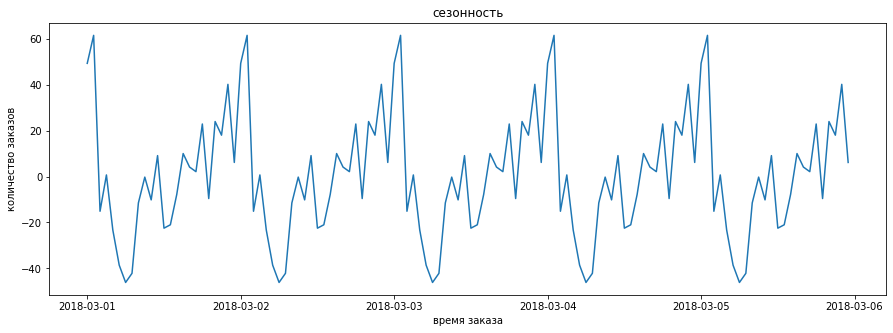

In [11]:
data_5 = data.loc["2018-03-01":"2018-03-05"]
dec = seasonal_decompose(data_5["num_orders"])
plt.figure(figsize=(15, 5))
plt.plot(dec.seasonal)
plt.title("сезонность")
plt.xlabel("время заказа")
plt.ylabel("количество заказов")
plt.show()

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Теперь видна сезоннсоть в заказах. Сезонность суточная, пик ее наблюдается к концу суток, а спады в начале. Природа сезонности возможно связана скорее всего с тем, что большее количестов самолетов прибывает в дневное-вечернее время, соответственно и такси заказываются больше в это время. 
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Учтено!
</div>

## Обучение

Далее приступим к обучению моделей. Считаю необходимым в рамках текущей задачи пользоваться двумя выборками: обучающей и тестовой. Применим стратегию TimeSeriesSplit для кросс-валидации временных рядов.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> 

Категорически с тобой не соглашусь:)
        
Ты прав насчёт того, что при обычной кросс-валидации фолды перемешиваются, и модель начинает "подсматривать" в будущее. Однако есть разные стратегии кросс-валидации, в том числе для временных рядов, одна из них (самая базовая) - `TimeSeriesSplit` (подробнее тут: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html). 
    
Также рекомендую почитать статью о сплитовании для временных рядов - даст понимание, как работает `TimeSeriesSplit`: https://medium.com/@Hong_Tang/timeseries-split-with-sklearn-tips-8162c83612b9. 
</div>

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>

Этот вывод стоит переписать - сейчас в работе используется кросс-валидация.
        
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.3 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Учтено!
</div>

In [12]:
data = data.drop("rolling_mean", axis = 1)

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Удалили ненужный признак - окей!
</div>

Теперь необходимо создать признаки для предсказания. Создадим календарные признаки: месяц, число, день недели, час. Также создадим несколько столбцов с отстающими значениями, максимальное отставание будем подбирать для каждой модели. Также будем подбирать оптимальный размер окна выборочного среднего. Для упрощения подбора создание признаков будем производиться функцией.

In [13]:
def features_creating(data, max_lag, rolling_mean_size):
    dc = data.copy()
    dc["day"] = dc.index.day
    dc['dayofweek'] = dc.index.dayofweek
    dc["hour"] = dc.index.hour
    
    for lag in range(1, max_lag + 1):
        dc['lag_{}'.format(lag)] = dc['num_orders'].shift(lag)
        
    dc['rolling_mean'] = dc['num_orders'].shift().rolling(rolling_mean_size).mean()
    return dc

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Написали функцию для создания новых признаков - окей!

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> 
Организация работы функции таким образом, чтобы она работала с глобальной переменной - не самая хорошая практика: если что-то пойдёт не так, придётся заново запускать весь процесс предобработки данных. 
        
Лучше организовывать функцию так, чтобы она принимала на вход набор данных и возвращала результат работы, чтобы его можно было сохранить в новой переменной. Концепт:
        
    def foo(df):
        df.dropna(inplace=True)
    
    foo(df)
        
В этом случае изменения необратимы, так как мы модифицировали глобальную переменную `df` - эту переменную придётся загружать в память заново и заново её обрабатывать.
        

    def foo(df):
        return df.dropna()
    
    foo(df)
        
        
Изменения будут необратимы и в таком случае, даже несмотря на на наличие `return`: несмотря на то, что работаем мы с локальной переменной, функция всё равно работает с объектом в памяти, связанным с глобальной переменной, пусть и через алиас.
        
    def foo(df):
        df_foo = df.copy()
        return df_foo.dropna()
    
    df_new = foo(df)
        
Здесь внутри функции исходный объект копируется, и работа уже происходит с новым объектом. В этом случае результат работы функции с исходными данными мы складываем в новую переменную - таким образом исходная глобальная переменная не подвергается вмешательству и сохранятся на случай, если функция сработала неправильно.
        
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Учтено!
</div>

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
Концептуально выделение признака "год" из даты - хорошая идея, но конкретно в нашем наборе данных у нас нет наблюдений в какой-то иной год, кроме 2018. Таким образом, мы просто создали константный признак, не приносящий ценности для модели, но расширяющий признаковое пространство. Стоит его удалить:)
        
То же касается признака "месяц": так как у нас данные только за неполный год и так как данные отстортированы по возрастанию даты, модель сможет работать адекватно только с теми значениями месяца, которые были на обучающей выборке. В оперативных данных таких значений месяца не будет, и модель не сможет работать с ними корректно.
        </div>

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Переписал функцию с локальными переменными, а также удалил неинформативный признак месяц.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Учтено!
</div>

In [14]:
data_new = features_creating(data, 24, 24)

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Новые признаки создали - отлично!

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> 
Давай немного порассуждаем о значении параметров этой функции:
        
1. Величина лага - показывает, на сколько шагов назад мы смотрим. В функции задано значение 7, соответственно наша будущая модель будет смотреть на 7 часов назад (так как в данных часовая грануляция). В целом неплохо, с этого можно начинать, но очевидно, что чем выше будет размер лага, тем точнее будут предсказания. 
2. Размер окна для скользящего среднего - показывает, сколько шагов мы будем использовать для расчёта среднего. Тут немного двоякий момент: если взять размер окна слишком маленьким, то модель будет быстрее схватывать новые тренды в данных, но не будет иметь достаточно истричности для формирования самого тренда, то есть получит хорошую уточняющую способность от оперативных данных, но уточнять особо будет нечего. С другой стороны, если задать слишком широкое окно для скользящего среднего, мы получим модель, хорошо помнящую, что было раньше, но довольно неповоротливую с точки зрения улавливания оперативных изменения - все вновь поступающие сигналы будут глушиться тяжёлым хвостом из прошлого.
        
В идеальном случае такие параметры лучше подбирать путём перебора: в цикла можно обучать простенькую модель вроде линейной регрессии с разными параметрами этой функции и замерять качество модели. Но в целом, так как у нас в данных имеется суточная сезонность, значение около 24 (плюс-минус) для обоих параметров будут оптимальными.
</div>

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Функцию возьмем с lag и размером окна по 24, так как имеем суточную сезонность.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Учтено!
</div>

In [15]:
data_new = data_new.dropna(axis = 0)

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Удалили строки, в которых после создания лаговых переменных появились пропуски - окей!

In [16]:
train, test = train_test_split(data_new, shuffle = False, test_size = 0.1)

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
Сплитование сделано корректно как с точки зрения учёта специфики временного ряда (отключено перемешивание), так и размера тестовой выборки.
</div>

In [17]:
train_target = train["num_orders"]
train_features = train.drop("num_orders", axis = 1)

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
Выделили признаки для обучения и целевой признак - хорошо!
</div>

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Применим кросс-валидацию для всех моделей, при этом применим параметр cv = TimeSeriesSplit для корректной валидации временных рядов.
</div>

Попробуем обучить модель линейной регрессии и посмотреть на ее результат метрики RMSE на валидационной выборке. Сделаем скорер для коректной работы GridSearchCV - минимизирующий метрику.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>

Тут некорректно: ни одна кросс-валидация не должна максимизировать `RMSE`, потому что сама суть этой функции потерь заключается в её минимизации. 
    
Скоррер `rmse` стоит удалить - он концептуально неверен.
        
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.3 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Учтено!
</div>

In [18]:
rmse_reverse = make_scorer(mean_squared_error, squared = False, greater_is_better = False)

In [19]:
tssv = TimeSeriesSplit()

In [20]:
model = LinearRegression()
model.fit(train_features, train_target)
cv_score = cross_val_score(model, train_features, train_target, scoring = rmse_reverse, cv = tssv).mean()
print("Метрика RMSE после кросс-валидации на линейной-регрессии:", cv_score)

Метрика RMSE после кросс-валидации на линейной-регрессии: -27.151211915470082


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
Обучили модель линейной регрессии и протестировали на валидационной выборке - окей!
</div>

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> 

Стоит добавить подпись данных в выводе кода (здесь и далее по всему блоку работы с моделями).
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
Учтено!
</div>

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
Раз уж далее мы проводим кросс-валидацию при подборе параметров, то давай сделаем её и для линейной регрессии. Так как в случае этого алгоритма подбирать параметры нам не нужно, мы можем использовать `cross_val_score` (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).
    
Несколько подсказок (актуально и для `cross_val_score`, и для `GridSearchCV`:
    
1. При работе с этими инструментами дополнительно выделять валидационную выборку не нужно: исходные данные делятся на тренировочный и тестовый сеты, инструменты работают только с тренировочными данными, кросс-валидация также проводится на тренировочных данных - инструменты сами в ходе кросс-валидиации делят выборку на фолды и проводят промежуточное тестирование.
2. Оценка на кросс-валидации в случае `cross_val_score` лежит в атрибуте `scores` (это то, что возвращает инструмент по завершении работы). Он представляет из себя массив, в котором лежит столько значений метрики, сколько фолдов указано при проведении кросс-валидации. Чтобы получить итоговую метрику качества на кросс-валидации, нужно взять среднее из этого массива, вроде:
        
        scores = cross_val_score(*твой код*)
        np.mean(scores) - усреднённая метрика качества на кросс-валидации
    В случае использования `GridSerachCV`/`RandomizedSearchCV` результаты кросс-валидации лежат в атрибуте `best_score_` - тут ничего не нужно усреднять, в атрибуте лежит уже усреднённая метрика. 
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
Учтено!
</div>

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>

Следует изменить скорринг.
        
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.3 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Учтено!
</div>

Попробуем обучить дерево решений, причем подберем парамеьры с помощью поиска по сетке. Для правильного подбора оптимальных параметров напишем скорер RMSE. Скорер должен показывать обратный RMSE, чтобы GridSerchCV показывал параметры модели, с лучшей метрикой.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
Создали скорринг для кросс-валидации - отлично!
</div>

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> 

Саму функцию `rmse` можно было бы и не объявлять: `make_scorer` прекрасно работает со всеми метриками в пакете `sklearn`. 
        
Например, `make_scorer(mean_squared_error, squared = False)`.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
Учтено!
</div>

In [21]:
parameter = {"max_depth": range(1,6)}
model = DecisionTreeRegressor()
model_grid = GridSearchCV(model, parameter, scoring = rmse_reverse, cv = tssv)
model_grid.fit(train_features, train_target)
print("Лучшая модель:", model_grid.best_estimator_)
print("RMSE:", model_grid.best_score_)

Лучшая модель: DecisionTreeRegressor(max_depth=5)
RMSE: -30.38527895593155


<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
Учтено!
</div>

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
При использовании `GridSearchCV` заново валидироваться не нужно - результаты внутренней кросс-валидации лежат в атрибуте `best_score_` (актуально здесь и далее).
        </div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
Учтено!
</div>

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Исправил кросс-валидацию и GridSearchCV. Есть вопрос к вам: если используем валидацию GridSearchCV и в нем scorer с параметром greater_is_better = False, то на выходе получим минимизированное значение метрики и оно будет отрицательное, подскажите каким образом выводить корректное значение best_score_
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
Да, ты верно заметил, что оно отрицательное - это особенности работы `GridSearchCV`. Для корректного отображения метрики её можно просто вывести по модулю. К примеру:
    
    print(-model_grid.best_score_)
</div>

Дерево решений дало лучший результат метрики RMSE на кросс-валидации. Проверим резкльтат метрики на ансамблях, начнем с RandomForestRegressor.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> 

Тут у нас уже кросс-валидация, а не валидационная выборка - стоит исправить вывод.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.3 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
Учтено!
</div>

In [22]:
parameter = {"max_depth": range(1,6), "n_estimators": range(1,100,4)}
model = RandomForestRegressor()
model_grid = GridSearchCV(model, parameter, scoring = rmse_reverse, cv = tssv)
model_grid.fit(train_features, train_target)
print("Лучшая модель:", model_grid.best_params_)
print("RMSE:", model_grid.best_score_)

Лучшая модель: {'max_depth': 5, 'n_estimators': 41}
RMSE: -27.087052966504654


Результат метрики RMSE на валидационной выборке равен 27.09, почти такая же как у линейной регрессии. Проверим результаты на моделе CatBoostRegressor. 

<div class="alert alert-warning">
    <h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> 

Вывод стоит подправить - метрика другая.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.3 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
Учтено!
</div>

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
Актуальны все предыдущие замечания.
        </div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
Учтено!
</div>

In [23]:
parameter = {"n_estimators": range(1,1000,50),"max_depth": range(1,6)}
model = CatBoostRegressor(verbose = False)
model_grid = GridSearchCV(model, parameter, scoring = rmse_reverse, cv = tssv)
model_grid.fit(train_features, train_target)
print("Лучшая модель:", model_grid.best_params_)
print("Результат:", model_grid.best_score_)

Лучшая модель: {'max_depth': 4, 'n_estimators': 501}
Результат: -24.227975499510244


Catboost показал лучший результат. Теперь посмотрим Ближайших соседей и сделаем вывод.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
Тут также стоит обратить внимание на список параметров:
1. `n_estimators` - ты, видимо, хотел последовательность от 1 до 1000 с шагов в 50, а получил список из 3 элементов - 1, 1000 и 50. Стоит использовать генераторы последовательностей, если передаёшь сразу списком:)
2. `max_depth` - аналогично деревьям, очень высокая глубина. Та же рекомендация по границам этого параметра.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
Учтено!
</div>

<div class="alert alert-warning">
    <h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> 

Аналогично про валидационную выборку.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.3 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
Учтено!
</div>

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> 

`CatBoost` обычно очень крут - после исправления ошибок результаты изменятся:)
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

Стало лучше:)
</div>

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
Актуальны все предыдущие замечания.
        </div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
Учтено!
</div>

In [24]:
model = KNeighborsRegressor(n_neighbors = 4)
model.fit(train_features, train_target)
cv_score = cross_val_score(model, train_features, train_target, scoring = rmse_reverse, cv = tssv).mean()
print("Метрика RMSE после кросс-валидации на ближайших соседях:", cv_score)

Метрика RMSE после кросс-валидации на ближайших соседях: -26.167320491977268


Значение RMSE ближайших соседей примерно равняется RMSE на линейной регрессии и случайном лесе. Таким образом лучшей моделью на кросс - валидации по значению метрики RMSE стала модель CatBoost. Проверим ее на тестовой выборке.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> 

Аналогично про валидационную выборку. Также теперь у тебя лучшая модель - не случайнй лес, а `CatBoost` - нужно изменить вывод.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.3 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
Учтено!
</div>

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> 

Здесь заканчивается стрктурный блок работы - стоит делать промежуточные выводы о проделанной работе, это довольно полезная практика, которая имеет большую ценность для получателя отчёта.
        
Достаточно будет двух-трёх тезисных предложений об основных шагах и полученных выводах.
        
</div>

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

По результатам кросс-валидации лучшей по метрике RMSE является модель CatBoostRegressor с оптимальными признаками. Правильная кросс-валидация улучшила метрики на всех моделях
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
Учтено!
</div>

## Тестирование

In [25]:
test_target = test["num_orders"]
test_features = test.drop("num_orders", axis = 1)

In [27]:
model = CatBoostRegressor(max_depth = 4, n_estimators = 501, verbose = False)
model.fit(train_features, train_target)
pred = model.predict(test_features)
print("Результат метрики RMSE модели CatBoostRegressor на тестовой выборке", mean_squared_error(test_target, pred, squared = False))

Результат метрики RMSE модели CatBoostRegressor на тестовой выборке 40.54227574124009


<div class="alert alert-warning">
    <h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> 

Вывод кода на экран стоит подписать.
        
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.3 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
Учтено!
</div>

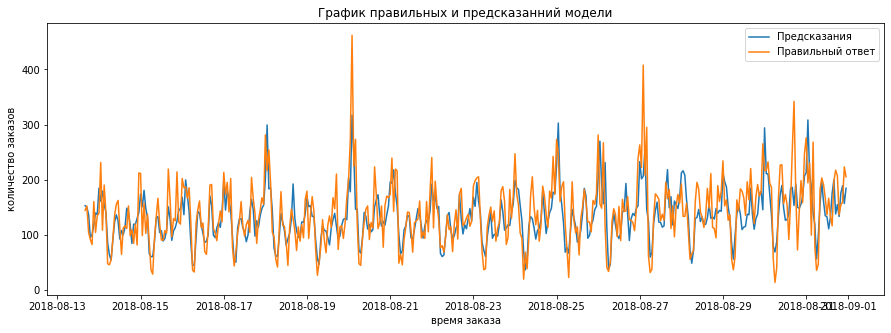

In [28]:
f = pd.DataFrame({"Предсказания":pred, "Правильные ответы":test_target})
plt.figure(figsize=(15, 5))
plt.plot(f["Предсказания"], label = "Предсказания")
plt.plot(f["Правильные ответы"], label = "Правильный ответ")
plt.title("График правильных и предсказанний модели")
plt.xlabel("время заказа")
plt.ylabel("количество заказов")
plt.legend()
plt.show()

По графику видно, что модель неправильно предсказывает значения, где в правильных ответах наблюдаются пики.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> 

Стоит оптимизировать размер - пока ничего непонятно.
        
Также давай прокомментируем, что видим из этого графика: в каких местах модель лучше справляется, в каких - ошибается?
        
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.3 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
Учтено!
</div>

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Сравним полученный результат CatBoostRegressor с наилучшеми параметрами с предсказанимями DummyRegressor.
</div>

In [29]:
model = DummyRegressor()
model.fit(train_features, train_target)
pred = model.predict(test_features)
mean_squared_error(test_target, pred, squared = False)

84.68768287118466

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
Протестировали лучшую модель на тестовой выборке - отлично! Результат буквально на границе допуска, но соответствует - окей!
    
Важный момент на будущее: если ты используешь тренировочную, валидационную и тестовую выборки, то после отбора кандидатов во время тестирования на тестовой выборке обучать лучшего кандидата стоит на соединённой тренировочной и валидационной выборке - так будет больше примеров для обучения, что особенно важно для временных рядов.

Значение метрики RMSE на тестовой выборке у случайного леса четко подходит по заданию проекта. В качестве вывода хотелось бы отметить, что при обучении и предсказании моделями на временных рядах очень большое значение имеет количество отстающих значений и размер окна в скользем среднем. Все задания проекта считаю выполнеными, лучшее значение метрики получилось у модели случайного леса с оптимальными параметрами.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> 

Здесь также было бы очень полезно визуализировать предсказания твоей лучшей модели и сравнить их с правильными ответами в формате линейного графика - так мы сможем более наглядно понять, в каких местах твоя модель делает хорошие предсказания, а в каких ошибается.

</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
Учтено!
</div>

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
Нет сравнения твоей лучшей модели с константной моделью: это важный шаг, который помогает оценить твою модель на адекватность: если она делает предсказания хуже константной модели, то смысл от внедрения такой модели крайне сомнительный.
    
В качестве константной модели можно использовать `DummyRegressor` (https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html) - он как раз для создания константных моделей:)

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
Учтено!
</div>

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Спасибо за качественную проверку. Очень много узнал о кросс-валидации временных рядов. Что касается проекта: мной были рассмотрены данные, проведена первичная обработка. Далее проведен анализ в ходе которого выявлен тренд, сезонность ряда. Далее мной были обучены и проверены с помощью кросс-валидации несколько моделей, из которых по результатам метрики RMSE была выявлена лучшая - СatBosstRegressor. Далее модель была протестирована на тестовой выборке, а ее результат был сравнен с предсказаниями константной модели, для понимания адекватности предсказаний. 
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
Тебе спасибо за то, что не ленишься учитывать мои комментарии и делать проект лучше:)
</div>

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Еше раз спасибо за проверку! Сейчас вроде все замечания исправлены))))
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.3 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
Да, теперь всё окей!
</div>

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> 
По завершении проекта стоит сделать итоговый вывод: в него можно включить основные шаги проекта, а также ключевые выводы, полученные в ходе работы над ним.
        </div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
Учтено!
</div>

<div style="border:solid Chocolate 2px; padding: 40px">

# Комментарий ревьюера: общий вывод по проекту.

Михаил, ты хорошо потрудился над этим проектом - работа получилась на довольно высоком уровне!

Ты верно выполнил все задания проекта, последовательно прошёл все его шаги, получил верные выводы и ничего не упустил в процессе - это классно, ты молодец!
    
Ты неплохо используешь визуализацию, умело подбираешь тип графиков для объяснения данных. Понравилось также, что ты не ограничился использованием простеньких алгоритмов типа линейной регрессии, а использовал более продвинутые инструменты вроде случайного леса и бустинга. Также реализован механизм подбора гиперпараметров моделей с помощью `GridSearchCV` - несомненный плюс!
    
В проекте есть рекомендации по повышению обшего качества твоего проекта. Несмотря на то, что они не являются критическими по степени влияния на итоговый результат, они всё же призваны обратить внимание на какие-то ошибки, неточности или узкиие моменты. Такие рекомендации я отметил жёлтыми комментариями. Будет здорово, если ты учтёшь их - так проект станет структурно и содержательно более совершенным.
    
Также в проекте есть критические замечания. Их я отметил комментариями красного цвета, в каждом из которых я оставил подсказку о том, как это замечание можно исправить. Важно устранить все критические замечания, чтобы проект был принят.
    
Если по тому, что нужно сделать, будут вопросы - оставь их, пожалуйста, в комментариях, и я отвечу на них во время следующего ревью:)
    
Также буду рад ответить на любые твои вопросы по проекту или на какие-либо другие, если они у тебя имеются - оставь их в комментариях, и я постараюсь ответить:)
    
Жду твой проект на повторном ревью. До встречи:)

<div style="border:solid Chocolate 2px; padding: 40px">

# Комментарий ревьюера: общий вывод по проекту v.2.

Михаил, спасибо, что прислал проект на повторное ревью: часть критических замечаний и рекомендаций была учтена.
    
Некоторые некритические замечания и рекомендации учтены не были: несмотря на то, что они не являются критическими по отношению к результату проекта, они всё ещё призваны обратить твоё внимание на незначительные ошибки, узкие места и неоптимальные решения, которые стоит исправить для повышения качества твоих решений будущих схожих задачи. Я всё же рекомендую учесть остаток некритических замечаний и рекомендаций.
    
Также есть несколько новых критических замечаний - они касаются частично аналитического блока, а также особенностей проведения кросс-валидации. К этим моментам стоит вернуться.
    
Если будут какие-то сложности - оставляй вопросы в комментариях, будем разбираться вместе:) 
    
Жду твою работу снова!

<div style="border:solid Chocolate 2px; padding: 40px">

# Комментарий ревьюера: общий вывод по проекту v.3.

Михаил, теперь к проекту нет вопросов - принимаю твою работу!
    
Спасибо за высокое качество проработки проекта и готовность его улучшать:)
    
Желаю успехов в дальнейшем обучении!